In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..', 'code'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [105]:
import os
from FaceRecognition import FaceRecognition
import cv2 as cv
from facenet_pytorch import InceptionResnetV1, MTCNN
import torch
from PIL import Image
from torchvision import transforms
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time
from modAL.models import ActiveLearner
import matplotlib.pyplot as plt
import pickle

In [28]:
ALIGNED_LABLED_DATA = '/media/mrj/documents/AI/FaceRecognition/data/labaled_data/aligned'
EMBEDD_LABLED_DATA = '/media/mrj/documents/AI/FaceRecognition/data/labaled_data/embedding'
IMAGES_LABLED_DATA  = '/media/mrj/documents/AI/FaceRecognition/data/labaled_data/images'

ALIGNED_UNLABLED_DATA = '/media/mrj/documents/AI/FaceRecognition/data/unlabled_data/aligned'
EMEBDD_UNLABLED_DATA = '/media/mrj/documents/AI/FaceRecognition/data/unlabled_data/embedding'
IMAGES_UNLABLED_DATA  = '/media/mrj/documents/AI/FaceRecognition/data/unlabled_data/images'

In [122]:
LABLES = os.listdir(IMAGES_LABLED_DATA)
NUM_DATA_EACH_LABEL = {}
for index, label in enumerate(LABLES):
    NUM_DATA_EACH_LABEL[label] = len(os.listdir(os.path.join(IMAGES_LABLED_DATA, label)))
sorted_dict = dict(sorted(NUM_DATA_EACH_LABEL.items(), key=lambda item: item[1], reverse=False))

LABLES = []
for key, value in sorted_dict.items():
    if  30 >value > 10:
        LABLES.append(key)
    if len(LABLES) == 20:
        break
print(len(LABLES))

20


In [91]:
Face = FaceRecognition()

In [123]:
X = []
Y = []

In [124]:
model = InceptionResnetV1(pretrained='vggface2').eval()
mtcnn = MTCNN(keep_all=True, device='cuda' if torch.cuda.is_available() else 'cpu')
preprocess = transforms.Compose([
            transforms.Resize((160, 160)),  # Resize to the required input size
            transforms.ToTensor(),         # Convert to tensor
            transforms.Normalize(           # Normalize with ImageNet mean and std
                mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5]
            )
        ])

for i, lable in enumerate(LABLES):
    print(f'\r{len(LABLES)}:{i}', end='')
    images_lable_path = os.path.join(IMAGES_LABLED_DATA, lable)
    aligned_lable_path = os.path.join(ALIGNED_LABLED_DATA, lable)
    
    for image_name in os.listdir(images_lable_path):
        image_path = os.path.join(images_lable_path, image_name)

        image = Image.open(image_path)

        boxes, probs = mtcnn.detect(image)
        if boxes is not None:
            for box in boxes:
                
                face = image.crop(box)
                face_tensor = preprocess(face).unsqueeze(0)
                with torch.no_grad():
                    embdeding = model(face_tensor).squeeze().numpy()
                X.append(embdeding)
                Y.append(lable)

classifier = RandomForestClassifier()
learner = ActiveLearner(classifier, X_training=X, y_training=Y)
print()
print(accuracy_score(Y, learner.predict(X)))

20:19
1.0


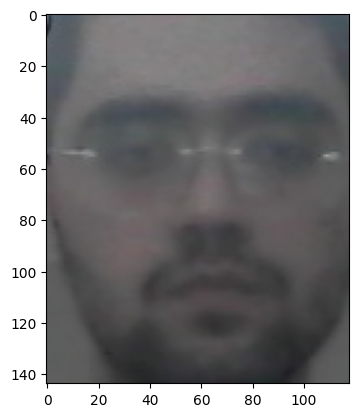

[0.15]
['Megawati_Sukarnoputri']


/media/mrj/documents/AI/FaceRecognition/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[0.6]
[0.11]
[0.24]


In [135]:
import numpy as np
learner = pickle.load(open('../models/learner.pkl', 'rb'))
image = Image.open('/media/mrj/documents/AI/FaceRecognition/test/20250114011243321277.jpg')
boxes, probs = mtcnn.detect(image)
embeddings = []
if boxes is not None:
    for box in boxes:
        face = image.crop(box)
        plt.imshow(face)
        plt.show()
        face_tensor = preprocess(face).unsqueeze(0)
        with torch.no_grad():
            embeddings.append(model(face_tensor).squeeze().numpy())
confidences = []
for x in embeddings:
    x = x.reshape(1, -1)
    probas = learner.predict_proba(x)
    confidence = max(probas[0])
    confidences.append(confidence)
print(np.array(confidences))
print(learner.predict(embeddings[0].reshape(1, -1)))
for index, x in enumerate(embeddings):
    x = x.reshape(1, -1)
    learner.teach(x, np.array([102+index]))

confidences = []
for x in embeddings:
    x = x.reshape(1, -1)
    probas = learner.predict_proba(x)
    confidence = max(probas[0])
    confidences.append(confidence)
print(np.array(confidences))


image = Image.open('/media/mrj/documents/AI/FaceRecognition/test/20250114011326397435.jpg')
boxes, probs = mtcnn.detect(image)
embeddings = []
if boxes is not None:
    for box in boxes:
        face = image.crop(box)
        face_tensor = preprocess(face).unsqueeze(0)
        with torch.no_grad():
            embeddings.append(model(face_tensor).squeeze().numpy())
confidences = []
for x in embeddings:
    x = x.reshape(1, -1)
    probas = learner.predict_proba(x)
    confidence = max(probas[0])
    confidences.append(confidence)
print(np.array(confidences))

image = Image.open('/media/mrj/documents/AI/FaceRecognition/api/static/images/11/20250114014136629664.jpg')
boxes, probs = mtcnn.detect(image)
embeddings = []
if boxes is not None:
    for box in boxes:
        face = image.crop(box)
        face_tensor = preprocess(face).unsqueeze(0)
        with torch.no_grad():
            embeddings.append(model(face_tensor).squeeze().numpy())
confidences = []
for x in embeddings:
    x = x.reshape(1, -1)
    probas = learner.predict_proba(x)
    confidence = max(probas[0])
    confidences.append(confidence)
print(np.array(confidences))

In [136]:
import numpy as np
# learner = pickle.load(open('../models/classic_online.pkl', 'rb'))
frame = cv.imread('../test/20250114011243321277.jpg')
gray_img = cv.cvtColor(frame, cv.COLOR_BGR2GRAY) 
faces, boxes = Face.detect_haar(gray_img, None)
if len(faces) == 0:
    print("\rNo Faces", end='')
    assert False
poses, aligned_faces = Face.pose_and_align(frame, boxes)

dlib_rect = boxes[0]
x1, y1, x2, y2 = dlib_rect.left(), dlib_rect.top(), dlib_rect.right(), dlib_rect.bottom()

embeddings = []
if boxes is not None:
    for box in boxes:
        face = Image.fromarray(aligned_faces[0])
        face_tensor = preprocess(face).unsqueeze(0)
        with torch.no_grad():
            embeddings.append(model(face_tensor).squeeze().numpy())

confidences = []
for x in embeddings:
    x = x.reshape(1, -1)
    probas = learner.predict_proba(x)
    confidence = max(probas[0])
    confidences.append(confidence)
print(np.array(confidences))
# for index, x in enumerate(embeddings):
#     print(index)
#     x = x.reshape(1, -1)
#     learner.teach(x, np.array([102+index]))

confidences = []
for x in embeddings:
    x = x.reshape(1, -1)
    probas = learner.predict_proba(x)
    confidence = max(probas[0])
    confidences.append(confidence)
print(np.array(confidences))


frame = cv.imread('../test/20250114011326397435.jpg')
gray_img = cv.cvtColor(frame, cv.COLOR_BGR2GRAY) 
faces, boxes = Face.detect_haar(frame, None)
if len(faces) == 0:
    print("\rNo Faces", end='')
    assert False
poses, aligned_faces = Face.pose_and_align(gray_img, boxes)
embeddings = Face.extract_embeddings(aligned_faces)
confidences = []
for x in embeddings:
    x = x.reshape(1, -1)
    probas = learner.predict_proba(x)
    confidence = max(probas[0])
    confidences.append(confidence)
print(np.array(confidences))

[0.11]
[0.11]
[0.13]
